In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
import datetime

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, Normalizer, LabelEncoder
from sklearn.feature_selection import SelectKBest,chi2,SelectFromModel
from xgboost import XGBClassifier, XGBRegressor
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from xgboost import plot_importance
from mlxtend.preprocessing import DenseTransformer
from mlxtend.feature_selection import ColumnSelector
from itertools import product

sns.set(color_codes=True)

# Features Engineering

## outliers

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y')
sales_df = pd.read_csv('../input/sales_train.csv', parse_dates = ['date'], date_parser=dateparse)

In [3]:
item_df = pd.read_csv('../input/items.csv')
shop_df = pd.read_csv('../input/shops.csv')
category_df = pd.read_csv('../input/item_categories.csv')

In [4]:
test_df = pd.read_csv('../input/test.csv').set_index('ID')

做类型整理，方便后面进行使用，使得pandas的dataframe所占用的内存变小

In [5]:
sales_df['date_block_num'] = sales_df['date_block_num'].astype('int8')
sales_df['shop_id'] = sales_df['shop_id'].astype('int16')
sales_df['item_id'] = sales_df['item_id'].astype('int16')
sales_df['item_price'] = sales_df['item_price'].astype('float32')
sales_df['item_cnt_day'] = sales_df['item_cnt_day'].astype('int16')

In [6]:
item_df['item_id'] = item_df['item_id'].astype('int16')
item_df['item_name'] = item_df['item_name'].astype('str')
item_df['item_category_id'] = item_df['item_category_id'].astype('int16')

In [7]:
shop_df['shop_name'] = shop_df['shop_name'].astype('str')
shop_df['shop_id'] = shop_df['shop_id'].astype('int16')

In [8]:
category_df['item_category_name'] = category_df['item_category_name'].astype('str')
category_df['item_category_id'] = category_df['item_category_id'].astype('int16')

### Clear the data out of range

In [9]:
sales_df = sales_df[sales_df.item_price<100000]
sales_df = sales_df[sales_df.item_cnt_day<1000]

### Correct the negative item price

In [10]:
sales_df[sales_df.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1


In [11]:
sales_df.at[484683, 'item_price'] = sales_df[(sales_df.item_id == 2973) & (sales_df.item_price > 0)].item_price.mean()

### Adjust duplicates by shop name

According to the reference, some shops are duplicates. This feature found is based on the language background.

In [12]:
shop_df[shop_df.shop_id == 0]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0


In [13]:
shop_df[shop_df.shop_id == 57]

,shop_name,shop_id
57,"Якутск Орджоникидзе, 56",57


The shop_id 0 and 57 are the same shop. And other pairs are 1 and 58, 10 and 11.

In [14]:
# Якутск Орджоникидзе, 56
sales_df.at[sales_df.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
sales_df.at[sales_df.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
sales_df.at[sales_df.shop_id == 10, 'shop_id'] = 11

## Extract Basic Features

In [15]:
def _rename(prefix):
    cols = ['2013-01', '2013-02', '2013-03', '2013-04','2013-05','2013-06','2013-07','2013-08','2013-09','2013-10','2013-11','2013-12','2014-01','2014-02','2014-03','2014-04','2014-05','2014-06','2014-07','2014-08','2014-09','2014-10','2014-11','2014-12','2015-01','2015-02','2015-03','2015-04','2015-05','2015-06','2015-07','2015-08', '2015-09','2015-10']
    
    result = {}
    for i in range(1, len(cols) + 1, 1):
        result[cols[i-1]] = prefix + str(i)
    
    return result

+ **Feature 'r' series**: Sales record

In [16]:
t = sales_df.groupby([sales_df.date.apply(lambda x: x.strftime('%Y-%m')),'item_id','shop_id']).agg({'item_cnt_day': 'sum'}).reset_index()

t = t[['date','item_id','shop_id','item_cnt_day']]
t = t.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
t = t.rename(index=str, columns=_rename('r'))

In [18]:
import gc

sales_record_df = t.copy()

del t
gc.collect()

28

In [19]:
sales_record_df[(sales_record_df.shop_id == 54) & (sales_record_df.item_id == 2)].head(20)

date,item_id,shop_id,r1,r2,r3,r4,r5,r6,r7,r8,...,r25,r26,r27,r28,r29,r30,r31,r32,r33,r34
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
for key in sales_record_df.columns.values:
    sales_record_df[key] = sales_record_df[key].astype('int16')

In [25]:
sales_record_df.shape

(418908, 36)

+ **Feature 'city'**: Each shop_name starts with the city name.

In [26]:
shop_df.loc[shop_df.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shop_df['shop_name'] = shop_df['shop_name'].astype(str)
shop_df['city'] = shop_df['shop_name'].str.split(' ').map(lambda x: x[0])
shop_df.loc[shop_df.city == '!Якутск', 'city'] = 'Якутск'

encoder = LabelEncoder()
encoder.fit(shop_df['city'])
shop_df['city_code'] = encoder.transform(shop_df['city'])

+ **Feature 'type'**: Each category contains type and subtype in its name.
+ **Feature 'subtype'**: Each category contains type and subtype in its name.

In [27]:
category_df['item_category_name'] = category_df['item_category_name'].astype(str)
category_df['type'] = category_df['item_category_name'].map(lambda x: x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(category_df['type'])
category_df['type_code'] = encoder.transform(category_df['type'])

In [28]:
category_df['subtype'] = category_df['item_category_name'].map(lambda x: x.split('-')[1].strip() if len(x.split('-')) > 1 else x.split('-')[0].strip())

encoder = LabelEncoder()
encoder.fit(category_df['subtype'])
category_df['subtype_code'] = encoder.transform(category_df['subtype'])

## Merge Data into one entity

In [29]:
sales_record_df = pd.merge(sales_record_df, item_df, on=['item_id'], how='left')
sales_record_df = pd.merge(sales_record_df, shop_df, on=['shop_id'], how='left')
sales_record_df = pd.merge(sales_record_df, category_df, on=['item_category_id'], how='left')

In [30]:
sales_record_df.head()

,item_id,shop_id,r1,r2,r3,r4,r5,r6,r7,r8,...,item_name,item_category_id,shop_name,city,city_code,item_category_name,type,type_code,subtype,subtype_code
0,0,54,0,0,0,0,0,0,0,0,...,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4
1,1,55,0,0,0,0,0,0,0,0,...,!ABBYY FineReader 12 Professional Edition Full...,76,Цифровой склад 1С-Онлайн,Цифровой,27,Программы - Для дома и офиса (Цифра),Программы,15,Для дома и офиса (Цифра),31
2,2,54,0,0,0,0,0,0,0,0,...,***В ЛУЧАХ СЛАВЫ (UNV) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4
3,3,54,0,0,0,0,0,0,0,0,...,***ГОЛУБАЯ ВОЛНА (Univ) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4
4,4,54,0,0,0,0,0,0,0,0,...,***КОРОБКА (СТЕКЛО) D,40,"Химки ТЦ ""Мега""",Химки,26,Кино - DVD,Кино,11,DVD,4


In [31]:
sales_record_df = sales_record_df.drop(['city', 'type', 'subtype', 'item_name', 'shop_name', 'item_category_name'], axis=1)

In [32]:
sales_record_df['item_category_id'] = sales_record_df['item_category_id'].astype('int16')
sales_record_df['city_code'] = sales_record_df['city_code'].astype('int16')
sales_record_df['type_code'] = sales_record_df['type_code'].astype('int16')
sales_record_df['subtype_code'] = sales_record_df['subtype_code'].astype('int16')

## Extract Aggragated Features

In [34]:
for i in range(1, 35, 1):
    t = sales_record_df.groupby(['item_category_id', 'shop_id'])['r'+str(i)].mean().astype('float32').reset_index(name='si'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['item_category_id', 'shop_id'], how='left')

In [36]:
for i in range(1, 35, 1):
    t = sales_record_df.groupby(['item_id'])['r'+str(i)].mean().astype('float32').reset_index(name='i'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['item_id'], how='left')

In [38]:
for i in range(1, 35, 1):
    t = sales_record_df.groupby(['shop_id'])['r'+str(i)].mean().astype('float32').reset_index(name='s'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['shop_id'], how='left')

In [41]:
for i in range(1, 35, 1):
    t = sales_record_df.groupby(['item_category_id'])['r'+str(i)].mean().astype('float32').reset_index(name='ic'+str(i))
    sales_record_df = pd.merge(sales_record_df, t, on=['item_category_id'], how='left')

In [42]:
sales_record_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418908 entries, 0 to 418907
Columns: 176 entries, item_id to ic34
dtypes: float32(136), int16(40)
memory usage: 252.5 MB


In [43]:
sales_record_df.columns.values

array(['item_id', 'shop_id', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7',
       'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17',
       'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26',
       'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'r33', 'r34',
       'item_category_id', 'city_code', 'type_code', 'subtype_code',
       'si1', 'si2', 'si3', 'si4', 'si5', 'si6', 'si7', 'si8', 'si9',
       'si10', 'si11', 'si12', 'si13', 'si14', 'si15', 'si16', 'si17',
       'si18', 'si19', 'si20', 'si21', 'si22', 'si23', 'si24', 'si25',
       'si26', 'si27', 'si28', 'si29', 'si30', 'si31', 'si32', 'si33',
       'si34', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9',
       'i10', 'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17', 'i18',
       'i19', 'i20', 'i21', 'i22', 'i23', 'i24', 'i25', 'i26', 'i27',
       'i28', 'i29', 'i30', 'i31', 'i32', 'i33', 'i34', 's1', 's2', 's3',
       's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13',
       's14', '

In [46]:
sales_record_df = sales_record_df.rename(index=str, columns={'r34': 'label'})
sales_record_df = sales_record_df.drop(['si34', 'i34', 's34', 'ic34'], axis=1)

In [47]:
sales_record_df.to_csv('../features/train.csv', index=False)

## Feature Selection

In [40]:
dataset = sales_record_df.copy()

In [61]:
dataset_alpha = sales_record_df.copy()
dataset_beta = sales_record_df.copy()

In [62]:
arr = []
for i in range(0, 33, 1):
    arr.append('r' + str(i))

rnames = dict(zip(dataset_beta.columns.values[2:36], arr))
dataset_beta = dataset_beta.rename(index=str, columns=rnames)
dataset_beta = dataset_beta.rename(index=str, columns={'r34': 'item_cnt_month'})

In [63]:
arr = []
for i in range(0, 33, 1):
    arr.append('p' + str(i))

rnames = dict(zip(dataset_beta.columns.values[36:70], arr))
dataset_beta = dataset_beta.rename(index=str, columns=rnames)

In [64]:
dataset_alpha = dataset_alpha.rename(index=str, columns={'r33': 'item_cnt_month'})

In [66]:
dataset_alpha.columns.values

array(['item_id', 'shop_id', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7',
       'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16', 'r17',
       'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26',
       'r27', 'r28', 'r29', 'r30', 'r31', 'r32', 'item_cnt_month', 'r34',
       'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11',
       'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20',
       'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29',
       'p30', 'p31', 'p32', 'p33', 'p34', 'item_category_id', 'city_code',
       'type_code', 'subtype_code'], dtype=object)

In [137]:
continuous = [
    'item_id', 'shop_id', 
    
    'r1', 'r2', 'r3', 'r4', 'r5', 'r6',
    'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'r13', 'r14', 'r15', 'r16',
    'r17', 'r18', 'r19', 'r20', 'r21', 'r22', 'r23', 'r24', 'r25',
    'r26', 'r27', 'r28', 'r29', 'r30', 'r31', 'r32',
    
#     'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8', 'p9', 'p10', 'p11',
#     'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20',
#     'p21', 'p22', 'p23', 'p24', 'p25', 'p26', 'p27', 'p28', 'p29',
#     'p30', 'p31', 'p32', 
    
    'item_category_id', 'city_code',
    'type_code', 'subtype_code'
]

fields = [
    
]

label = ['item_cnt_month']

len(continuous)

38

In [138]:
features_pipeline = Pipeline([
    ('features', FeatureUnion([
        ('continuous', Pipeline([
            ('extract', ColumnSelector(continuous)),
            ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('normalize', Normalizer())
        ])),
    ])),
])

features_pipeline.fit(dataset_beta, dataset_beta[label].values.ravel())

train_dataset_x = features_pipeline.transform(dataset_beta)
train_dataset_y = dataset_beta[label].values.ravel()

valid_dataset_x = features_pipeline.transform(dataset_alpha)
valid_dataset_y = dataset_alpha[label].values.ravel()

In [139]:
selector_model = XGBRegressor(max_depth=10, n_estimators=50, random_state=0)
selector_model.fit(train_dataset_x, train_dataset_y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [140]:
thresh = 0.0
selection = SelectFromModel(selector_model, threshold=thresh, prefit=True)

train_dataset_x = selection.transform(train_dataset_x)
valid_dataset_x = selection.transform(valid_dataset_x)

In [141]:
selector_model.feature_importances_

array([0.13970008, 0.08940231, 0.01112148, 0.00660113, 0.00760565,
       0.01104972, 0.00638588, 0.00308531, 0.00459209, 0.00530961,
       0.0047356 , 0.00624238, 0.00660113, 0.00574012, 0.00638588,
       0.00538136, 0.00459209, 0.00574012, 0.00609887, 0.00581187,
       0.00566836, 0.01140848, 0.0271938 , 0.01406328, 0.02138193,
       0.01384803, 0.01922939, 0.02511301, 0.03465595, 0.02532826,
       0.03386668, 0.04305087, 0.04757121, 0.08459496, 0.0718232 ,
       0.03817177, 0.05847744, 0.08237067], dtype=float32)

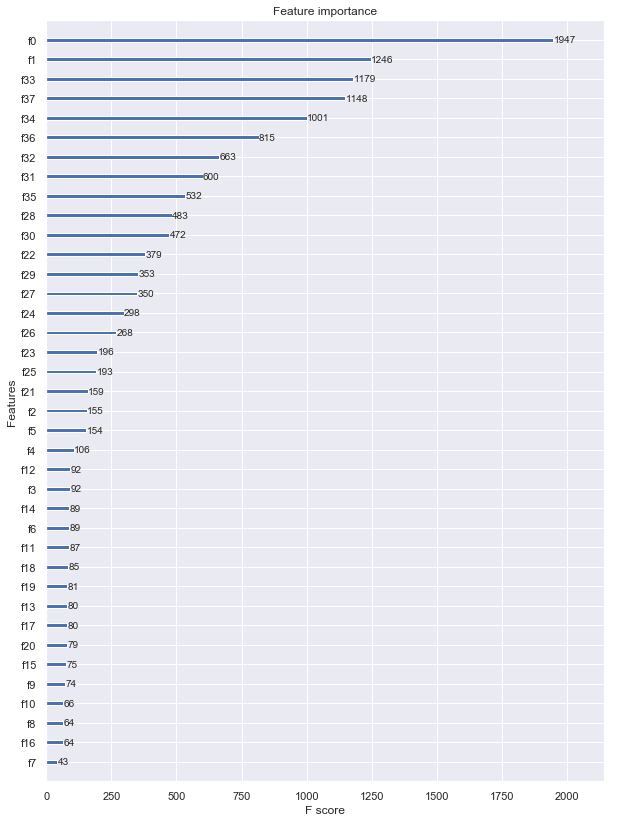

In [142]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(selector_model, (10,14))

## Train

In [ ]:
import xgboost as xgb

params = {'max_depth':12, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'silent':0,
         'eval_metric':'rmse'}

train_dmatrix = xgb.DMatrix(train_dataset_x, label=train_dataset_y)
valid_dmatrix = xgb.DMatrix(valid_dataset_x, label=valid_dataset_y)

# # 使用xgb.cv优化num_boost_round参数
cvresult = xgb.cv(params, xgb_dmatrix, num_boost_round=10000, seed=2019, callbacks=[
    xgb.callback.print_evaluation(show_stdv=False),
    xgb.callback.early_stop(30)
])
num_round_best = cvresult.shape[0] - 1
print('Best round num: ', num_round_best)

In [153]:
# watchlist = [(train_dmatrix, 'train'), (valid_dmatrix, 'validate')] 
# model = xgb.train(params, train_dmatrix, evals=watchlist, early_stopping_rounds=10, num_boost_round=num_round_best)

xgb_dmatrix = xgb.DMatrix(train_dataset_x + valid_dataset_x, label=train_dataset_y + valid_dataset_y)
model = xgb.train(params, xgb_dmatrix, num_boost_round=num_round_best)

[15:41:53] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 0 pruned nodes, max_depth=12
[15:41:56] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 962 extra nodes, 0 pruned nodes, max_depth=12
[15:41:59] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 984 extra nodes, 0 pruned nodes, max_depth=12
[15:42:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 1004 extra nodes, 0 pruned nodes, max_depth=12
[15:42:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 974 extra nodes, 0 pruned nodes, max_depth=12
[15:42:08] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 954 extra nodes, 0 pruned nodes, max_depth=12
[15:42:11] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 846 extra nodes, 0 pruned nodes, max_depth=12
[15:42:14] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 852 extra nodes, 0 pruned nodes, max_depth=12
[15:42:17] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 782 extra nodes, 0 

In [154]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred = model.predict(valid_dmatrix)
sqrt(mean_squared_error(valid_dataset_y, pred))

4.700167210627865

## Predict

In [146]:
dataset = sales_record_df.copy()

In [147]:
arr = []
for i in range(-2, 32, 1):
    arr.append('r' + str(i))

rnames = dict(zip(dataset.columns.values[2:36], arr))
dataset = dataset.rename(index=str, columns=rnames)

In [148]:
arr = []
for i in range(-2, 32, 1):
    arr.append('p' + str(i))

rnames = dict(zip(dataset.columns.values[36:70], arr))
dataset = dataset.rename(index=str, columns=rnames)

In [149]:
dataset_predict = pd.merge(test_df, dataset, on=['item_id', 'shop_id'], how='left')

predict_dataset_x = features_pipeline.transform(dataset_predict)
predict_dataset_x = selection.transform(predict_dataset_x)

predict_dmatrix = xgb.DMatrix(predict_dataset_x)

pred = model.predict(predict_dmatrix)

/Users/leewind/.local/share/virtualenvs/leewind-p6XO93Th/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [150]:
pred = list(map(lambda x: min(20,max(x,0)), list(pred)))

submission = pd.DataFrame({
    "ID": test_df.index, 
    "item_cnt_month": pred
})

submission.to_csv('submission.csv', index=False)

# Reference

## Normal ML Analysis

+ [Feature engineering, xgboost](https://www.kaggle.com/dlarionov/feature-engineering-xgboost)
+ [Predicting sales using Lightgbm](https://www.kaggle.com/sanket30/predicting-sales-using-lightgbm)

## Time Series

对于revenge的预测很有帮助，但是对于单个店的单个商品而言没有实际的意义，这种预测方式的学习非常有益处

+ [AR(I)MA时间序列建模过程——步骤和python代码](https://www.jianshu.com/p/cced6617b423)
+ [python时间序列分析](http://www.cnblogs.com/foley/p/5582358.html)
+ [AR、MA及ARMA模型](https://zhuanlan.zhihu.com/p/22248464)
+ [Time Series with Python (ODSC) STA.ipynb](https://github.com/ultimatist/ODSC17/blob/master/Time%20Series%20with%20Python%20(ODSC)%20STA.ipynb)
+ [Getting Started with Time Series](https://pyflux.readthedocs.io/en/latest/getting_started.html)
+ [Welcome to Statsmodels’s Documentation](http://www.statsmodels.org/devel/index.html)